# Final Notebook
# AirBnB Prediction Kaggle Competition
## W207 Machine Learning
## Chris Caudill, Tarun Chopra, Olivier Zimmer, Matt Acconciamessa


### Please keep in mind that this Kaggle competition calculated accuracy scores based on the top 5 most likely predictions. Accuracies reported in this notebook will not match the associated Kaggle score.

# Table of Contents:

### Feature Engineering
### Model 1: Logistic Regression
### Model 2: AdaBoost Decision Tree
### Model 3: K-Nearest Neighbor
### Model 4: Neural Network
### Appendix: Models that did not improve accuracy
### Model 5: Multinomial Naive Bayes
### Model 6: Principal Component Analysis + Gaussian Mixture Modeling

In [5]:
import warnings
warnings.filterwarnings('ignore')

#General Use
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import string
from datetime import datetime

# Regression
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

# GMM
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture

# Multinomial Naive Bayes & KNN
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Tensorflow
import tempfile
import math
from sklearn import preprocessing
import tensorflow as tf
import tensorflow.contrib.learn.python.learn as learn
from sklearn import datasets, metrics, preprocessing

# Load Training and Test data

In [44]:
df_train = pd.read_csv('./../train_users_2.csv')
df_test = pd.read_csv('./../test_users.csv')
id_test = df_test['id']
labels = df_train['country_destination'].values
df_train = df_train.drop(['country_destination'], axis=1)
piv_train = df_train.shape[0]

# Feature Engineering

In [45]:
#Some Feature Engineering inspired by http://blog.kaggle.com/2016/03/07/airbnb-new-user-bookings-winners-interview-3rd-place-sandro-vega-pons/

# split date fields into 3 columns (year, month, day) to avoid having a feature for every possible date
dac = np.vstack(df_train.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('/')))).values)
df_train['acct_create_month'] = dac[:,0]
df_train['acct_create_day'] = dac[:,1]
df_train['acct_create_year'] = dac[:,2]

# train and test data use different formats, so this is doing the same thing as above
dac = np.vstack(df_test.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_test['acct_create_month'] = dac[:,1]
df_test['acct_create_day'] = dac[:,2]
df_test['acct_create_year'] = dac[:,0]

# concatenate the train and test user files
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

# concat account create month/year
df_all['acct_create_month_year'] = df_all.acct_create_month.astype(str) +'/'+ df_all.acct_create_year.astype(str)

# drop columns unecessary for prediction
df_all = df_all.drop(['id', 'date_first_booking','date_account_created','timestamp_first_active','acct_create_day','acct_create_month','acct_create_year'], axis=1)

#set unknown gender values to NA
df_all.gender = df_all.gender.replace('-unknown-',np.nan)

#fill NA values with -1
df_all = df_all.fillna(-1)

# The age field is populated with some outlying values and some year values (e.g., 2014)
# This will pull only ages between 14 and 100
av = df_all.age.values
df_all['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

# encode categorical features with dummy values
categorical = ['acct_create_month_year', 'age', 'gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in categorical:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)
    
print "Done!"

Done!


# Split Training data into 2 sets to allow us to have a development set

In [46]:
# After cleansing, split the data back up between the train and test users
vals = df_all.values
full_train = vals[:piv_train]
full_test = vals[piv_train:]

# Split training values between train & dev sets 

np.random.seed(0)
msk = np.random.rand(len(full_train)) < 0.75

split_train_data = full_train[msk]
split_train_labels = labels[msk]

split_dev_data = full_train[~msk]
split_dev_labels = labels[~msk]

In [47]:
n = 10000
split_train_data = split_train_data[:n]
split_train_labels = split_train_labels[:n]
split_dev_data = split_dev_data[:n]
split_dev_labels = split_dev_labels[:n]
full_train = full_train[:n]
full_test = full_test[:n]
labels = labels[:n]
id_test = id_test[:n]

# Function to generate the submission file for Kaggle

As mentioned at the top of this notebook, the Kaggle competition calculates accuracy scores based on the 5 predictions with the highest prediction probability. This function outputs those top five predictions. 

NOTE: To use this function, you must uncomment the "return()" line from within the associated model's function below

In [34]:
def GenerateSubmission(preds):
    le = LabelEncoder().fit(split_train_labels)
    #Taking the 5 classes with highest probabilities
    user_ids = []
    countries = []
    for i in range(len(id_test)):
        idx = id_test[i]
        user_ids += [idx] * 5
        countries += le.inverse_transform(np.argsort(preds[i])[::-1])[:5].tolist()
    ## Output predictions to CSV
    sub = pd.DataFrame(np.column_stack((user_ids, countries)), columns=['id', 'country'])
    sub.to_csv('submission.csv',index=False)
    
#GenerateSubmission(LogReg())

---
# Model 1: Logistic Regression Model
## Final Kaggle Score: 86.72%
---
#### Here we are iterating through a list of regularization strengths to identify the optimal value. 

"The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features." - Homework 2 Problem 6

While developing our model, we tested both L1 and L2 regularization and noticed a very slight difference. L1 resulted in roughly a 0.1% increase in accuracy in both our development data and on Kaggle's test data.

Once we've identified the optimal regularization strength, we execute the model with these optimized settings and output our predictions.

Optimal Regularization Strength: {'C': 0.01}
LogReg F1: 0.5395


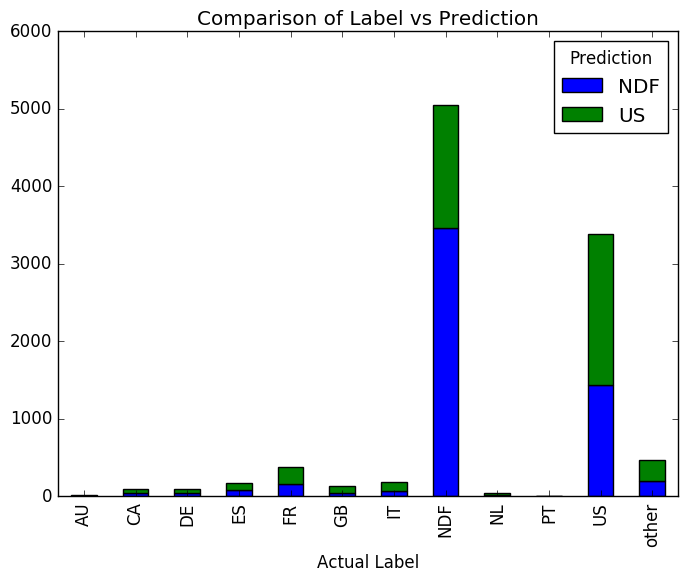

In [ ]:
def LogReg():
    strengths = {'C': [0.0001,0.001,0.01,0.1,0.3,0.5,1.0]}

    # GridSearch for optimal regularization strength
    clf_lr = GridSearchCV(LogisticRegression(multi_class='ovr',penalty='l1'), strengths, scoring='f1_micro')

    ################################
    # Fitting 75% of the training set and then predicting the remaining 25%
    ################################

    clf_lr.fit(split_train_data, split_train_labels)

    # development predictions
    dev_preds = clf_lr.predict(split_dev_data)

    print "Optimal Regularization Strength:", clf_lr.best_params_
    print "LogReg F1:", metrics.f1_score(split_dev_labels, dev_preds, average='micro')
    
    # Plot the predictions vs actual labels
    ct = pd.crosstab(split_dev_labels,dev_preds, rownames=['Actual Label'],colnames=['Prediction'])
    plt.rcParams['font.size'] = 12.0
    ct.plot(kind="bar",
            title="Comparison of Label vs Prediction",
            figsize=(8,6),
            stacked=True)
    plt.show()

    ################################
    # Fitting the full training set and predicting on the test set
    ################################
    clf_lr.fit(full_train, labels)
    test_preds = clf_lr.predict_proba(full_test)
    
    #Uncomment this line before generating results
    #return(test_preds)
    
LogReg()

---
# Model 2: AdaBoost Decision Trees
## Final Kaggle Score: 86.63%
---

### Due to the nature of our data being multi-classification, we've set this model up in 2 separate ways:
We are simultaneously running this model using both SAMME.R and SAMME algorithms and comparing their performance. These algorithms are two variations of the loss function that is used to adjust the model's weights throughout the training. While SAMME.R uses classifications to update the additive model, SAMME uses probability estimates.

SAMME Accuracy: 55.1
SAMME.R Accuracy 54.32


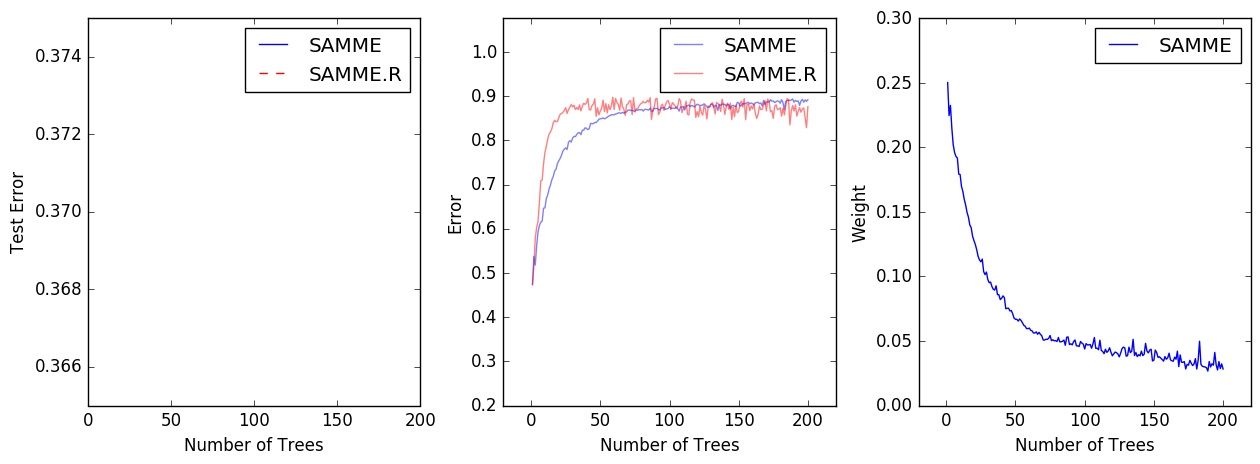

In [53]:
def AdaBoostDT():
#Source: http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html

    # default algorithm used: 'SAMME.R'
    bdt_real = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3),
        n_estimators=200,
        learning_rate=0.1)

    # using 'SAMME'
    bdt_discrete = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3),
        n_estimators=200,
        learning_rate=0.1,
        algorithm="SAMME")

    # Fit model using 75/25 split of training data
    bdt_real.fit(split_train_data, split_train_labels)
    bdt_discrete.fit(split_train_data, split_train_labels)

    real_test_errors = []
    discrete_test_errors = []

    # Adjust weights throughout predictions
    for real_test_predict, discrete_train_predict in zip(
            bdt_real.staged_predict(split_dev_data), bdt_discrete.staged_predict(split_dev_data)):
        real_test_errors.append(
            1. - accuracy_score(real_test_predict, split_dev_labels))
        discrete_test_errors.append(
            1. - accuracy_score(discrete_train_predict, split_dev_labels))

    n_trees_discrete = len(bdt_discrete)
    n_trees_real = len(bdt_real)

    # Boosting might terminate early, but the following arrays are always
    # n_estimators long. We crop them to the actual number of trees here:
    discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
    real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
    discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

    # Print Accuracies
    print "SAMME Accuracy:", round(accuracy_score(discrete_train_predict,split_dev_labels),6)*100
    print "SAMME.R Accuracy", round(accuracy_score(real_test_predict,split_dev_labels),6)*100

    # Make Predictions for full test data
    bdt_discrete_preds = bdt_discrete.predict_proba(full_test)
    bdt_preds = bdt_real.predict_proba(full_test)

    # After training the model above, we can now plot the error rates in 3 different diagrams.
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.plot(range(1, n_trees_discrete + 1),
             discrete_test_errors, c='blue', label='SAMME')
    plt.plot(range(1, n_trees_real + 1),
             real_test_errors, c='red',
             linestyle='dashed', label='SAMME.R')
    plt.legend()
    plt.ylim(0.365, 0.375)
    plt.ylabel('Test Error')
    plt.xlabel('Number of Trees')

    plt.subplot(132)
    plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
             "b", label='SAMME', alpha=.5)
    plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
             "r", label='SAMME.R', alpha=.5)
    plt.legend()
    plt.ylabel('Error')
    plt.xlabel('Number of Trees')
    plt.ylim((.2,
             max(real_estimator_errors.max(),
                 discrete_estimator_errors.max()) * 1.2))
    plt.xlim((-20, len(bdt_discrete) + 20))

    plt.subplot(133)
    plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
             "b", label='SAMME')
    plt.legend()
    plt.ylabel('Weight')
    plt.xlabel('Number of Trees')
    plt.ylim((0, discrete_estimator_weights.max() * 1.2))
    plt.xlim((-20, n_trees_discrete + 20))

    # prevent overlapping y-axis labels
    plt.subplots_adjust(wspace=0.25)
    plt.show()
    
    #Uncomment this line before generating results
    #return(bdt_discrete_preds)
AdaBoostDT()

---
# Model 3: K-Nearest Neighbor
## Final Kaggle Score: 72.77%
---

In [52]:
def KNN(k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(split_train_data, split_train_labels)
    dev_preds = knn.predict(split_dev_data)
    print "K:", k, "F1:", metrics.f1_score(split_dev_labels, dev_preds,average='weighted')

    knn.fit(full_train, labels)
    test_preds = knn.predict_proba(full_test)
    
    #Uncomment this line before generating results
    #return(test_preds)
KNN(1)

K: 1 F1: 0.409603251179


---
# Model 4: Neural Networks using Tensorflow
### Final Kaggle Score: 86.82%
---
## NOTE: We used a slightly different approach for Feature Engineering with this model. This is why we re-execute those similar steps again.
---

# Load training and test data

In [4]:
train_users = pd.read_csv("/Users/ozimmer/Google Drive/berkeley/w207/final project/Group_Project/train_users_2.csv")
test_users = pd.read_csv("/Users/ozimmer/Google Drive/berkeley/w207/final project/Group_Project/test_users.csv")
test_id = test_users['id']

## Feature engineering ***SPECIFICALLY FOR TENSORFLOW***

In [3]:
df_train = train_users
df_test = test_users

# concatenate the train and test user files
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

# split date fields into 3 columns (year, month, day) to avoid having a feature for every possible date
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_all['acct_create_year'] = dac[:,0]
df_all['acct_create_month'] = dac[:,1]
df_all['acct_create_day'] = dac[:,2]

# concat account create month/year
df_all['acct_create_month_year'] = df_all.acct_create_month.astype(str) +'/'+ df_all.acct_create_year.astype(str)

# drop columns unecessary for prediction
df_all = df_all.drop(['id', 'date_first_booking','date_account_created','timestamp_first_active','acct_create_day','acct_create_month','acct_create_year'], axis=1)

#set unknown gender values to NA
df_all.gender = df_all.gender.replace('-unknown-',np.nan)

#fill NA values with -1
df_all = df_all.fillna("NaN")

# The age field is populated with some outlying values and some year values (e.g., 2014)
# This will pull only ages between 14 and 100
av = df_all.age.values
df_all['age'] = np.where(np.logical_or(av<14, av>100), 0, av)

#Encode label in integer for TensorFlow
le = preprocessing.LabelEncoder()
le.fit(df_all["country_destination"])
df_all["label"] = le.transform(df_all["country_destination"])

In [5]:
# After cleansing, split the data back up between the train and test users
length_training_set = train_users.shape[0]
train_values = df_all[:length_training_set] 
test_data = df_all[length_training_set:]

# Split training values between train & dev sets 
np.random.seed(0)
msk = np.random.rand(len(train_values)) < 0.75
train_data = train_values[msk]
dev_data = train_values[~msk]

## Linear classifier using TensorFlow

In [6]:
#Continuous variables are converted into a Tensor while Categorical variables are converted into a SparseTensor
CATEGORICAL_COLUMNS = ["gender", "signup_method", "language", "affiliate_channel", "affiliate_provider", "first_affiliate_tracked",
                        "signup_app", "first_device_type", "first_browser", "acct_create_month_year"]

CONTINUOUS_COLUMNS = ["age", "signup_flow"]

LABEL_COLUMN = "label" 

def input_fn(df):
    # Creates a dictionary mapping from each continuous feature column name (k) to
    # the values of that column stored in a constant Tensor.
    continuous_cols = {k: tf.constant(df[k].values.astype(int)) for k in CONTINUOUS_COLUMNS}
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(df[k].size)],
                                           values=df[k].values,
                                           shape=[df[k].size, 1])
                        for k in CATEGORICAL_COLUMNS}
    # Merges the two dictionaries into one.
    feature_cols = dict(continuous_cols.items() + categorical_cols.items())
    # Converts the label column into a constant Tensor.
    label = tf.constant(df[LABEL_COLUMN].values)
    # Returns the feature columns and the label.
    return feature_cols, label

def train_input_fn():
    return input_fn(train_data)

def eval_input_fn():
    return input_fn(dev_data)

def test_input_fn():
    return input_fn(test_data)

# Defining FeatureColumns and Creating the Regressor (no data here, just the structure)
gender = tf.contrib.layers.sparse_column_with_hash_bucket("gender", hash_bucket_size=4)
signup_method = tf.contrib.layers.sparse_column_with_hash_bucket("signup_method", hash_bucket_size=3)
language = tf.contrib.layers.sparse_column_with_hash_bucket("language", hash_bucket_size=25)
affiliate_channel = tf.contrib.layers.sparse_column_with_hash_bucket("affiliate_channel", hash_bucket_size=8)
affiliate_provider = tf.contrib.layers.sparse_column_with_hash_bucket("affiliate_provider", hash_bucket_size=18)
first_affiliate_tracked = tf.contrib.layers.sparse_column_with_hash_bucket("first_affiliate_tracked", hash_bucket_size=8)
signup_app = tf.contrib.layers.sparse_column_with_hash_bucket("signup_app", hash_bucket_size=4)
first_device_type = tf.contrib.layers.sparse_column_with_hash_bucket("first_device_type", hash_bucket_size=9)
first_browser = tf.contrib.layers.sparse_column_with_hash_bucket("first_browser", hash_bucket_size=49)
acct_create_month_year = tf.contrib.layers.sparse_column_with_hash_bucket("acct_create_month_year", hash_bucket_size=54)

age = tf.contrib.layers.real_valued_column("age")
signup_flow = tf.contrib.layers.real_valued_column("signup_flow")

#Building the model
model_dir = tempfile.mkdtemp()
m = tf.contrib.learn.LinearClassifier(feature_columns=[gender, signup_method, language, 
                                                        affiliate_channel, affiliate_provider, 
                                                        first_affiliate_tracked, signup_app, first_device_type, 
                                                        first_browser, acct_create_month_year, age, signup_flow],
                                      n_classes= 13, 
                                      model_dir=model_dir)

#Fit - calling now for the data
m.fit(input_fn = eval_input_fn, steps = 200)

results = m.evaluate(input_fn = eval_input_fn, steps=1)
for key in sorted(results):
     print "%s: %s" % (key, results[key])

y = m.predict_proba(input_fn = test_input_fn)

user_ids = []  #list of ids
countries = []  #list of countries
for i in range(len(test_id)):
    idx = test_id[i]
    user_ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(y[i])[::-1])[:5].tolist()
sub = pd.DataFrame(np.column_stack((user_ids, countries)), columns=['id', 'country'])
sub.to_csv('sub_LinearClassifier.csv',index=False)

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


accuracy: 0.60515
global_step: 200
loss: 1.10624


## DNN model using Tensorflow

In [8]:
deep_columns = [
tf.contrib.layers.embedding_column(gender, dimension=4),
tf.contrib.layers.embedding_column(signup_method, dimension=3),
tf.contrib.layers.embedding_column(language, dimension=20), #25
tf.contrib.layers.embedding_column(affiliate_channel, dimension=8),
tf.contrib.layers.embedding_column(affiliate_provider, dimension=8), #18
tf.contrib.layers.embedding_column(first_affiliate_tracked, dimension=8),
tf.contrib.layers.embedding_column(signup_app, dimension=4),
tf.contrib.layers.embedding_column(first_device_type, dimension=8), #9
tf.contrib.layers.embedding_column(first_browser, dimension=20), #49
tf.contrib.layers.embedding_column(acct_create_month_year, dimension=20), #54
age,
signup_flow
]

model_dir = tempfile.mkdtemp()
dnn = tf.contrib.learn.DNNLinearCombinedClassifier(
    model_dir = model_dir,
    dnn_feature_columns=deep_columns,
    dnn_hidden_units=[10, 20, 10],
    n_classes= 13)

dnn.fit(input_fn = train_input_fn, steps = 500)

# results = dnn.evaluate(input_fn = train_input_fn, steps=1)
# for key in sorted(results):
#      print "%s: %s" % (key, results[key])

results = dnn.evaluate(input_fn = eval_input_fn, steps=1)
for key in sorted(results):
     print "%s: %s" % (key, results[key])
        
ydnn = dnn.predict_proba(input_fn = test_input_fn)

user_ids = []  #list of ids
countries = []  #list of countries
for i in range(len(test_id)):
    idx = test_id[i]
    user_ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(ydnn[i])[::-1])[:5].tolist()
sub = pd.DataFrame(np.column_stack((user_ids, countries)), columns=['id', 'country'])
sub.to_csv('sub_DNNLinearCombinedClassifier.csv',index=False)

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


accuracy: 0.628328
global_step: 500
loss: 1.09088


## Looping through parameters
### a. Steps

In [24]:
STEPS = [1, 10, 50, 100, 500, 1000, 2000] 
HIDDEN_UNITS = [10, 20, 10]
periods = 5

dnn_learning_steps = tf.contrib.learn.DNNLinearCombinedClassifier(
    model_dir = model_dir,
    dnn_feature_columns = deep_columns,
    dnn_hidden_units = HIDDEN_UNITS,
    n_classes= 13)

accuracy_trainings = []
accuracy_validations = []
for step in STEPS:
    dnn_learning_steps.fit(
    input_fn = train_input_fn,
    steps = step
    )
    
    accuracy_training = dnn_learning_steps.evaluate(input_fn = train_input_fn, steps = 1)
    accuracy_validation = dnn_learning_steps.evaluate(input_fn = eval_input_fn, steps = 1)
        
    accuracy_trainings.append(accuracy_training['accuracy'])
    accuracy_validations.append(accuracy_validation['accuracy'])

    print "  step %i : %3.3f" % (step, accuracy_training['accuracy'])

# Output a graph of loss metrics over periods.
plt.figure(figsize=(4,3))
plt.ylabel("Accuracy")
plt.xlabel("Steps")
plt.title("Neural Network Accuracy vs. steps", fontsize= 10)
plt.plot(STEPS, accuracy_trainings, label='training')
plt.plot(STEPS, accuracy_validations, label='validation')
plt.legend(loc = 4, fontsize= 10)
plt.show()

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


NotFoundError: Tensor name "dnn/hiddenlayer_1/biases" not found in checkpoint files /var/folders/8f/trt1_g696bjcs2035zpz6l2m002_wl/T/tmpfrJayf/model.ckpt-10-?????-of-00001
	 [[Node: save/restore_slice_6 = RestoreSlice[dt=DT_FLOAT, preferred_shard=0, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/restore_slice_6/tensor_name, save/restore_slice_6/shape_and_slice)]]

Caused by op u'save/restore_slice_6', defined at:
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-93fa39b37086>", line 16, in <module>
    steps = step
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/estimator.py", line 333, in fit
    max_steps=max_steps)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/estimator.py", line 708, in _train_model
    max_steps=max_steps)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/graph_actions.py", line 281, in _monitored_train
    hooks=all_hooks) as super_sess:
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/monitored_session.py", line 342, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/monitored_session.py", line 511, in __init__
    _WrappedSession.__init__(self, self._sess_creator.create_session())
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/monitored_session.py", line 400, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/monitored_session.py", line 245, in create_session
    self._scaffold.finalize()
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/monitored_session.py", line 148, in finalize
    self._saver.build()
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1106, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 700, in build
    restore_sequentially, reshape)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 484, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 441, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 281, in restore_op
    preferred_shard=preferred_shard))
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/io_ops.py", line 204, in _restore_slice
    preferred_shard, name=name)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/ozimmer/anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "dnn/hiddenlayer_1/biases" not found in checkpoint files /var/folders/8f/trt1_g696bjcs2035zpz6l2m002_wl/T/tmpfrJayf/model.ckpt-10-?????-of-00001
	 [[Node: save/restore_slice_6 = RestoreSlice[dt=DT_FLOAT, preferred_shard=0, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/restore_slice_6/tensor_name, save/restore_slice_6/shape_and_slice)]]


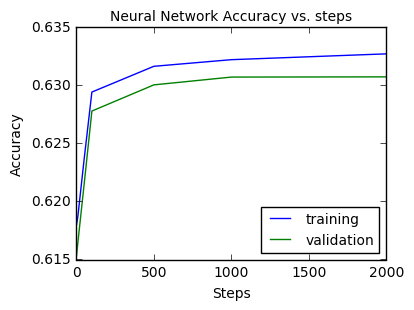

In [42]:
plt.figure(figsize=(4,3))
plt.ylabel("Accuracy")
plt.xlabel("Steps")
plt.title("Neural Network Accuracy vs. steps", fontsize= 10)
plt.plot(STEPS, accuracy_trainings, label='training')
plt.plot(STEPS, accuracy_validations, label='validation')
plt.legend(loc = 4, fontsize= 10)
plt.show()

### b. Number of hidden units

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


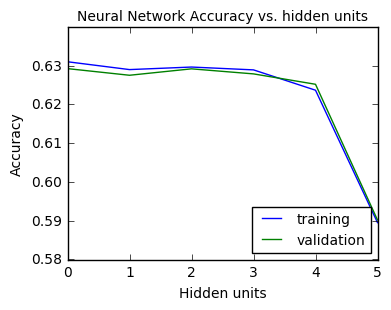

In [22]:
# Loop through hidden units parameter
step = 500
HIDDEN_UNITS = [[10],[10, 10],[10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10, 10], [10, 10, 10, 10, 10, 10]]

def DNN_parameters(step_arg, hidden_unit):

    model_dir = tempfile.mkdtemp()
    dnn_hidden = tf.contrib.learn.DNNLinearCombinedClassifier(
        model_dir = model_dir,
        dnn_feature_columns=deep_columns,
        dnn_hidden_units=hidden_unit,
        n_classes= 13)
    dnn_hidden.fit(input_fn = train_input_fn, steps = step_arg)
    
    accuracy_training = dnn_hidden.evaluate(input_fn = train_input_fn, steps = 1)
    accuracy_validation = dnn_hidden.evaluate(input_fn = eval_input_fn, steps = 1)
    return accuracy_training['accuracy'], accuracy_validation['accuracy']

accuracy_trainings = []
accuracy_validations = []
for hidden_unit in HIDDEN_UNITS:
    accuracies = DNN_parameters(step_arg = 500, hidden_unit = hidden_unit)
    accuracy_trainings.append(accuracies[0])
    accuracy_validations.append(accuracies[1])

# Output a graph of loss metrics over periods.
plt.figure(figsize=(4,3))
plt.ylabel("Accuracy")
plt.xlabel("# of Hidden units")
plt.title("Neural Network Accuracy vs. # of hidden units", fontsize= 10)
plt.plot(accuracy_trainings, label='training')
plt.plot(accuracy_validations, label='validation')
plt.legend(loc = 4, fontsize= 10)
plt.show()


# APPENDIX
## Model 5: Multinomial Naive Bayes
## Model 6: Principal Component Analysis + Gaussian Mixture Modeling

---
# Model 5: Multinomial Naive Bayes
## Final Kaggle Score: 59.75%
---

In [51]:
def MNB():
    alpha = {'alpha': [0.0001, 0.01, .05, 0.1, 0.2, 1.0]}

    # GridSearch for optimal regularization strength
    clf_nb = GridSearchCV(MultinomialNB(), alpha, scoring='f1_micro')

    # Fitting 75% of the training set and then predicting the remaining 25%
    clf_nb.fit(split_train_data, split_train_labels)

    # development predictions
    dev_preds = clf_nb.predict(split_dev_data)

    print "Optimal Regularization Strength:", clf_nb.best_params_
    print "MNB F1:", metrics.f1_score(split_dev_labels, dev_preds, average='micro')

    # Fitting the full training set and predicting on the test set
    clf_nb.fit(full_train, labels)
    test_preds = clf_nb.predict_proba(full_test)
    
    #Uncomment this line before generating results
    #return (test_preds)
MNB()

Optimal Regularization Strength: {'alpha': 1.0}
MNB F1: 0.3858


---
# Model 6: Principal Component Analysis + Gaussian Mixture Modeling
## Final Kaggle Score: 39%
---

# Plot the incremental increase in explained variance as the number of components increases

90% explained variance achieved at: 41 components


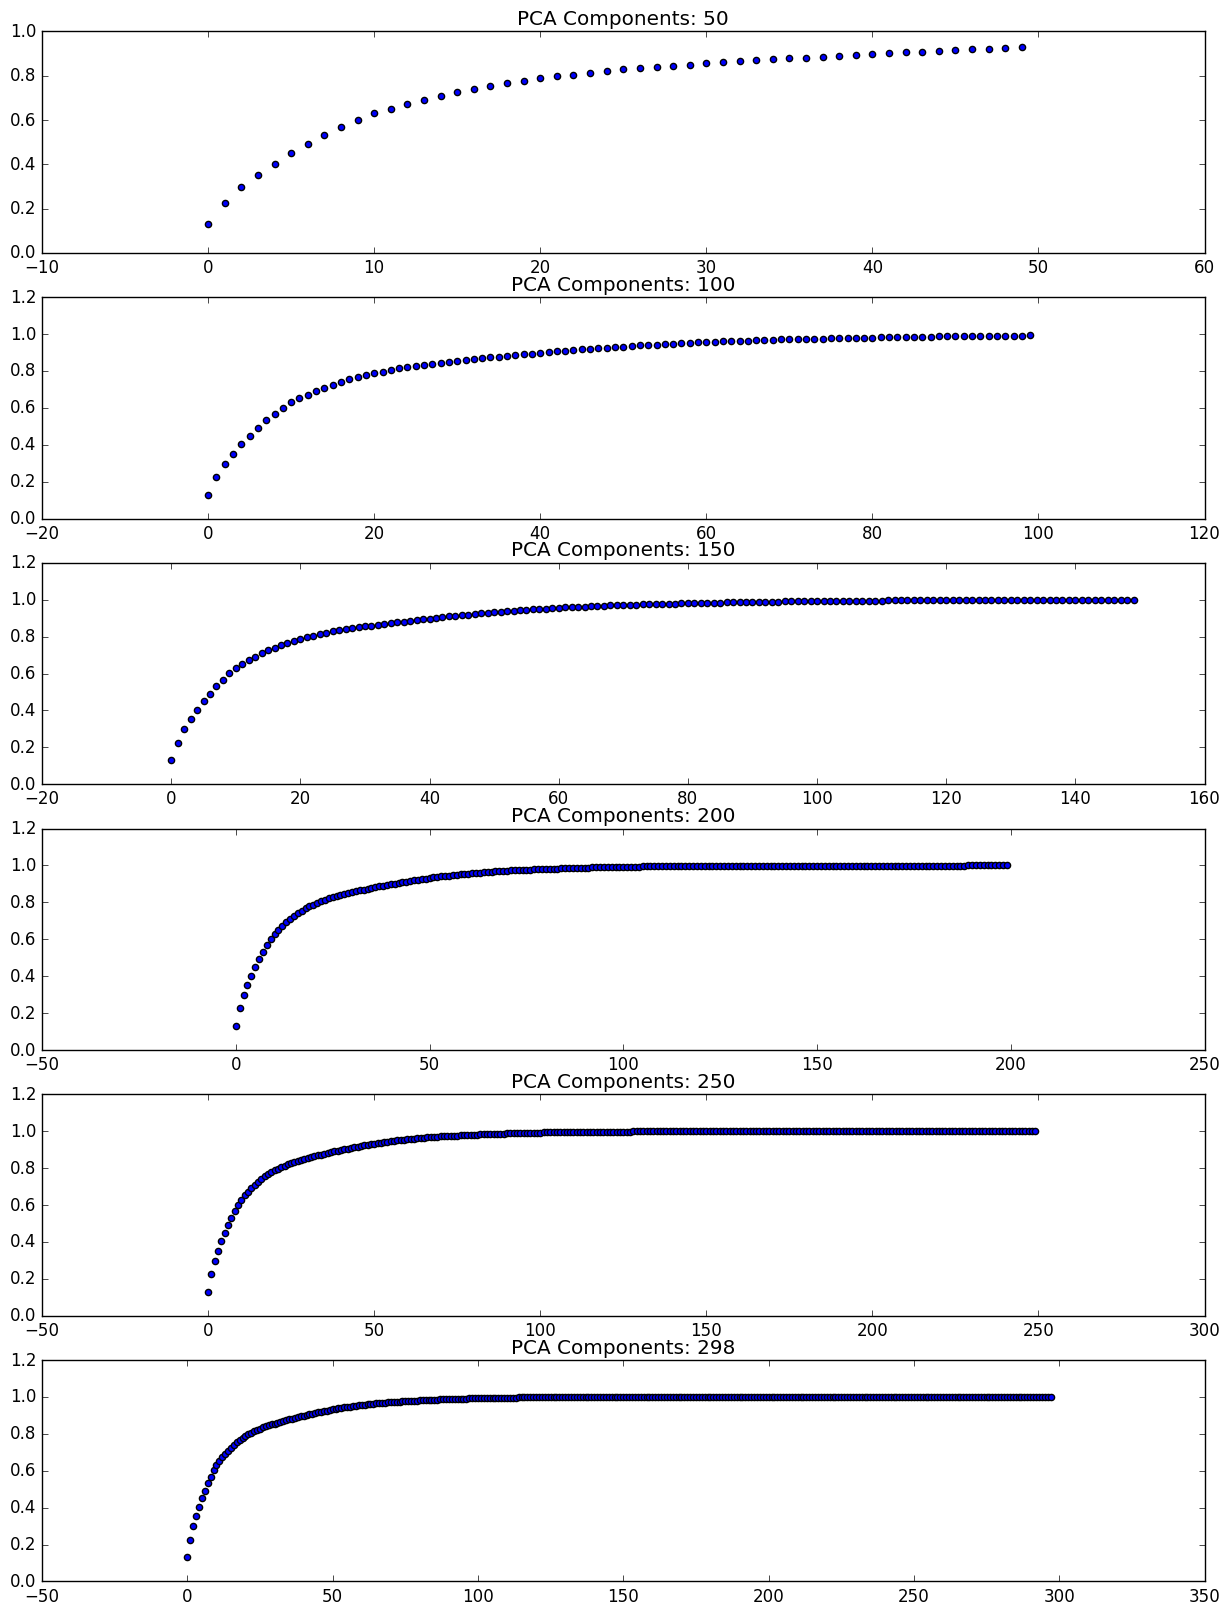

In [50]:
def PCA_Plot():
    pca_feat = [50,100,150,200,250,298]
    plt.figure(figsize=(15,20))

    # Loop through the pca component values
    for i in range(len(pca_feat)):

        # Fit PCA
        k_pca = PCA(n_components=pca_feat[i]).fit(full_train)

        # Establish temporary variables
        cum_vars = []
        p1_cum_var = 0
        target=0

        # Create Subplot
        ax = plt.subplot(len(pca_feat),1,i+1)

        # loop through each individual PCA component and create a list of the 
        # incremental increases of explained variance
        for k in range(pca_feat[i]):
            p1_cum_var += k_pca.explained_variance_ratio_[k]
            cum_vars.append(p1_cum_var)

            # Identify the point where we have 90% explained variance
            if((p1_cum_var >= 0.9) & (target==0)):
                target = k 

        # Plot the data
        plt.scatter(range(pca_feat[i]),cum_vars)
        plt.title("PCA Components: %s" % pca_feat[i])
    print "90% explained variance achieved at:", target, "components"
    plt.show()
PCA_Plot()

# Plot the scatter of each country's training data from a 2-dimension PCA

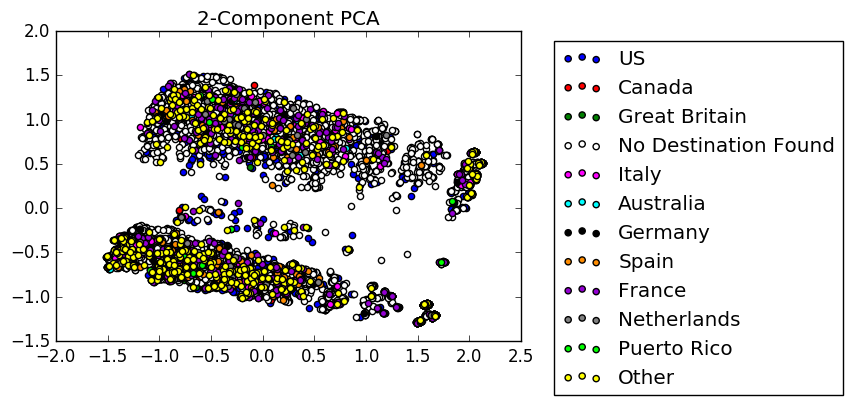

In [49]:
def PCA_Scatter():
    # Fit 2-dimensional PCA
    pca_2d=PCA(n_components=2)
    pca_train = pca_2d.fit_transform(split_train_data)

    # Split 2d PCA data into poisonous and not-poisonous sets
    pca_train_US = pca_train[np.where(split_train_labels=='US')]
    pca_train_CA = pca_train[np.where(split_train_labels=='CA')]
    pca_train_GB = pca_train[np.where(split_train_labels=='GB')]
    pca_train_NDF = pca_train[np.where(split_train_labels=='NDF')]
    pca_train_IT = pca_train[np.where(split_train_labels=='IT')]
    pca_train_AU = pca_train[np.where(split_train_labels=='AU')]
    pca_train_DE = pca_train[np.where(split_train_labels=='DE')]
    pca_train_ES = pca_train[np.where(split_train_labels=='ES')]
    pca_train_FR = pca_train[np.where(split_train_labels=='FR')]
    pca_train_NL = pca_train[np.where(split_train_labels=='NL')]
    pca_train_PT = pca_train[np.where(split_train_labels=='PT')]
    pca_train_other = pca_train[np.where(split_train_labels=='other')]

    # Plot the data
    plt.scatter(pca_train_US[:,0],pca_train_US[:,1],c='blue',label="US")
    plt.scatter(pca_train_CA[:,0],pca_train_CA[:,1],c='red',label="Canada")
    plt.scatter(pca_train_GB[:,0],pca_train_GB[:,1],c='green',label="Great Britain")
    plt.scatter(pca_train_NDF[:,0],pca_train_NDF[:,1],c='white',label="No Destination Found")
    plt.scatter(pca_train_IT[:,0],pca_train_IT[:,1],c='magenta',label="Italy")
    plt.scatter(pca_train_AU[:,0],pca_train_AU[:,1],c='cyan',label="Australia")
    plt.scatter(pca_train_DE[:,0],pca_train_DE[:,1],c='black',label="Germany")
    plt.scatter(pca_train_ES[:,0],pca_train_ES[:,1],c='darkorange',label="Spain")
    plt.scatter(pca_train_FR[:,0],pca_train_FR[:,1],c='darkviolet',label="France")
    plt.scatter(pca_train_NL[:,0],pca_train_NL[:,1],c='gray',label="Netherlands")
    plt.scatter(pca_train_PT[:,0],pca_train_PT[:,1],c='lime',label="Puerto Rico")
    plt.scatter(pca_train_other[:,0],pca_train_other[:,1],c='yellow',label="Other")


    plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
    plt.title("2-Component PCA")
    plt.show()
PCA_Scatter()

# Make predictions using PCA and GMM scores

In [48]:
def GMM_Predict(pca_feat, gmm_comp, cov_type,test_data):
    k_pca = PCA(n_components=pca_feat)

    pca_train = k_pca.fit_transform(split_train_data)
    pca_dev = k_pca.transform(test_data)
    
    pca_train_US = pca_train[np.where(split_train_labels=='US')]
    pca_train_CA = pca_train[np.where(split_train_labels=='CA')]
    pca_train_GB = pca_train[np.where(split_train_labels=='GB')]
    pca_train_NDF = pca_train[np.where(split_train_labels=='NDF')]
    pca_train_IT = pca_train[np.where(split_train_labels=='IT')]
    pca_train_AU = pca_train[np.where(split_train_labels=='AU')]
    pca_train_DE = pca_train[np.where(split_train_labels=='DE')]
    pca_train_ES = pca_train[np.where(split_train_labels=='ES')]
    pca_train_FR = pca_train[np.where(split_train_labels=='FR')]
    pca_train_NL = pca_train[np.where(split_train_labels=='NL')]
    pca_train_PT = pca_train[np.where(split_train_labels=='PT')]
    pca_train_other = pca_train[np.where(split_train_labels=='other')]

    US_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_US)
    CA_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_CA)
    GB_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_GB)
    NDF_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_NDF)
    IT_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_IT)
    AU_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_AU)
    DE_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_DE)
    ES_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_ES)
    FR_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_FR)
    NL_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_NL)
    PT_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_PT)
    other_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_other)

    gmm_preds = []
    score_label = ['US','CA','GB','NDF','IT','AU','DE','ES','FR','NL','PT','other']
    for i in range(len(pca_dev)):
        scores = []
        scores.append(US_gmm.score(pca_dev[i]))
        scores.append(CA_gmm.score(pca_dev[i]))
        scores.append(GB_gmm.score(pca_dev[i]))
        scores.append(NDF_gmm.score(pca_dev[i]))
        scores.append(IT_gmm.score(pca_dev[i]))
        scores.append(AU_gmm.score(pca_dev[i]))
        scores.append(DE_gmm.score(pca_dev[i]))
        scores.append(ES_gmm.score(pca_dev[i]))
        scores.append(FR_gmm.score(pca_dev[i]))
        scores.append(NL_gmm.score(pca_dev[i]))
        scores.append(PT_gmm.score(pca_dev[i]))
        scores.append(other_gmm.score(pca_dev[i]))
        optimal_idx = np.where(scores==max(scores))[0][0]
        gmm_preds.append(score_label[optimal_idx])
        
    return(gmm_preds)
    # Calculate accuracy of predictions
print "GMM Prediction Accuracy:", round(np.mean(GMM_Predict(2,4,'full',split_dev_data)==split_dev_labels),4)*100

GMM Prediction Accuracy: 8.77
